In [1]:
import sys
import logging

handler = logging.StreamHandler(sys.stdout)
logging.getLogger().setLevel(logging.DEBUG)  # events of this level and above will be tracked
handler.setFormatter(
    logging.Formatter("\n%(asctime)s: %(levelname)s: %(module)s.%(funcName)s:\n%(message)s", "%y-%m-%d %H:%M:%S")
)
logging.getLogger().handlers = [handler,]

In [2]:
from elfpy.strategies.basic import BasicPolicy

class Shorter(BasicPolicy):
    """
    Agent that is trying to optimize on a rising vault APR via shorts
    """

    def __init__(self, market, rng, wallet_address, budget=10_000):
        """call basic policy init then add custom stuff"""
        self.pt_to_short = 1000
        super().__init__(market, rng, wallet_address, budget)

    def action(self):
        """
        implement user strategy
        short if you can, only once
        """
        block_position_list = list(self.wallet.token_in_protocol.values())
        has_opened_short = bool(any((x < -1 for x in block_position_list)))
        can_open_short = self.get_max_pt_short() >= self.pt_to_short
        action_list = []
        if can_open_short:
            if self.market.vault_apy > self.market.get_rate(): #if self.market.get_rate() / self.market.vault_apy <= 0.2: # pool APR is less than 20% of the vault APR
                action_list.append(self.create_agent_action(action_type="open_short", trade_amount=self.pt_to_short))
            elif self.market.vault_apy < self.market.get_rate():
                if has_opened_short:
                    action_list.append(self.create_agent_action(action_type="close_short", trade_amount=self.pt_to_short))
        return action_list

In [3]:
import numpy as np

from elfpy.utils.parse_config import parse_simulation_config
from elfpy.simulators import YieldSimulator

In [4]:
config = parse_simulation_config(config_dict={
    'title': 'demo simulation config',
    'market': {
        'min_target_liquidity': 1_000_000.0,
        'max_target_liquidity': 10_000_000.0,
        'min_target_volume': 0.001,
        'max_target_volume': 0.01,
        'min_vault_age': 0,
        'max_vault_age': 1,
        'min_vault_apy': 0.001,
        'max_vault_apy': 0.9,
        'base_asset_price': 1
    },
    'amm': {
        'min_fee': 0.1,
        'max_fee': 0.5,
        'min_pool_apy': 0.02,
        'max_pool_apy': 0.9,
        'floor_fee': 0,
        'verbose': False
    },
    'simulator': {
        'num_trading_days': 10,#180,
        'num_blocks_per_day': 100,#7_200,
        'token_duration': 0.2465753424657534,
        'precision': 64,
        'pricing_model_name': 'Hyperdrive',
        'user_policies': [],
        'shuffle_users': True,
        'init_lp': True,
        'random_seed': 123,
        'logging_level': 'info'
    }
})

In [5]:
simulator = YieldSimulator(config)
simulator.reset_rng(
    np.random.default_rng(simulator.config.simulator.random_seed)
)
simulator.set_random_variables()

ramp = np.linspace(start=0.05, stop=0.1, num=config.simulator.num_trading_days)
override_dict = {
    "pricing_model_name": "HyperDrive",
    "target_liquidity": 10e6,
    "fee_percent": 0.1,
    "init_pool_apy": 0.05,
    "vault_apy": ramp,
    "num_blocks_per_day": 1,  # 1 block a day, keep it fast for testing
}

simulator.setup_simulated_entities(override_dict)
simulator.agents.update(
    {1: Shorter(
            market=simulator.market,
            rng=simulator.rng,
            wallet_address=1
        )
    }
)
simulator.agents.update(
    {2: Shorter(
        market=simulator.market,
        rng=simulator.rng,
        wallet_address=2
    )
    }
)
simulator.run_simulation()


22-12-05 22:11:13: INFO: simulators.log_config_variables:
{
  "amm": {
    "floor_fee": 0,
    "max_fee": 0.5,
    "max_pool_apy": 0.9,
    "min_fee": 0.1,
    "min_pool_apy": 0.02,
    "verbose": false
  },
  "market": {
    "base_asset_price": 1,
    "max_target_liquidity": 10000000.0,
    "max_target_volume": 0.01,
    "max_vault_age": 1,
    "max_vault_apy": 0.9,
    "min_target_liquidity": 1000000.0,
    "min_target_volume": 0.001,
    "min_vault_age": 0,
    "min_vault_apy": 0.001
  },
  "simulator": {
    "fee_percent": 0,
    "init_lp": true,
    "init_pool_apy": 0,
    "init_vault_age": 0,
    "logging_level": 20,
    "num_blocks_per_day": 100,
    "num_trading_days": 10,
    "pool_duration": 180,
    "precision": 64,
    "pricing_model_name": "Hyperdrive",
    "random_seed": 123,
    "shuffle_users": true,
    "target_daily_volume": 0,
    "target_liquidity": 0,
    "token_duration": 0.2465753424657534,
    "user_policies": [],
    "vault_apy": [],
    "verbose": false
  }
}

In [6]:
from elfpy.utils.data import format_trades

[trades, trades_agg] = format_trades(simulator.analysis_dict)


22-12-05 22:11:14: DEBUG: __init__.wrapper:
matplotlib data path: /Users/dylan/.pyenv/versions/3.10.4/lib/python3.10/site-packages/matplotlib/mpl-data

22-12-05 22:11:14: DEBUG: __init__.wrapper:
CONFIGDIR=/Users/dylan/.matplotlib

22-12-05 22:11:14: DEBUG: __init__.<module>:
interactive is False

22-12-05 22:11:14: DEBUG: __init__.<module>:
platform is darwin

22-12-05 22:11:14: DEBUG: __init__.wrapper:
CACHEDIR=/Users/dylan/.matplotlib

22-12-05 22:11:14: DEBUG: font_manager._load_fontmanager:
Using fontManager instance from /Users/dylan/.matplotlib/fontlist-v330.json


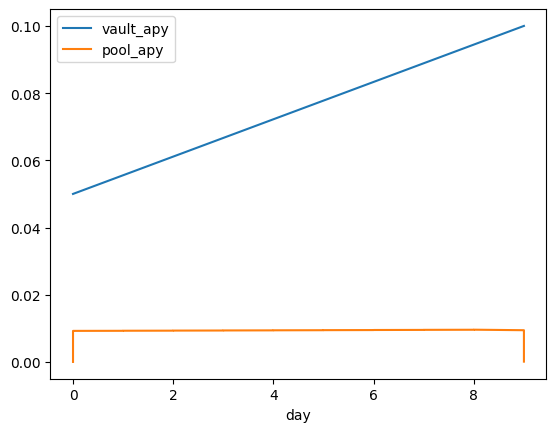

In [7]:
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)  # events of this level and above will be tracked

fig, ax = plt.subplots()
ax = trades.plot(x="day", y="vault_apy", ax=ax)
ax = trades.plot(x="day", y="pool_apy", ax=ax)